In [0]:
%pip install -U openai

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

#Motivation & Purpose: 
### This notebook is intended to demonstrate the use of our tools within the agent-based system as standalone components, allowing them to be run easily and conveniently without relying on the agent itself, due to UI issues and integration challenges. Here, you can see our two main tools, their purposes, and the outputs they produce, the answer & insights that LLM gives based on their outputs including the visualizations of the generated graphs.

In [0]:
#Connect to LLM model- FREE model
from openai import OpenAI
import json

def ask_llm_expert(data_json, user_question, system_prompt, report_title="STRATEGIC REPORT"):
    client = OpenAI(
        api_key="PUT API KEY FROM APPENDIX NAMED- API KEY FOR NOTEBOOK TOOLS ONLY", 
        base_url="https://api.groq.com/openai/v1"
    )

    if isinstance(data_json, dict):
        data_json = {k: v for k, v in data_json.items() if k != "ui_artifacts"}

    model_id = "llama-3.3-70b-versatile"
    
    full_context = f"""
    {system_prompt}
    
    Analysis Data:
    {json.dumps(data_json, ensure_ascii=False)}
    
    User Question:
    "{user_question}"
    """
    
    try:
        print(f"📡 Sending request to Groq for: {report_title}...")
        
        response = client.chat.completions.create(
            model=model_id,
            messages=[
                {"role": "system", "content": "You are a professional Airbnb Strategy Consultant."},
                {"role": "user", "content": full_context}
            ],
            temperature=0.1 
        )
        
        answer = response.choices[0].message.content
        print("\n" + "="*60)
        print(f"✅ {report_title}")
        print("="*60)
        print(answer)
        print("="*60 + "\n")
        return answer
        
    except Exception as e:
        error_msg = f"❌ Error: {str(e)}"
        print(error_msg)
        return error_msg

In [0]:
# Put proprty id that you would like to check the tools on:
property_id = "40458495"

In [0]:
#Imports
import io
import json
import regex as re
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler, Imputer, StandardScaler)
from pyspark.ml.regression import LinearRegression
from pyspark.sql import DataFrame
from pyspark.ml.functions import vector_to_array

#First Tool- Regression model

### Goal: 
The purpose of this tool is to give property owners a clear understanding of what truly affects their rating and how they can realistically improve it.

Total features: 30
Data ready and cached.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run hilarious-mare-138 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871/runs/a6633dbe29034a44ba10df3f0ec96874
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871
Model trained successfully.
🕵️ Analyzing Property: 40458495...

📊 VISUAL ANALYSIS


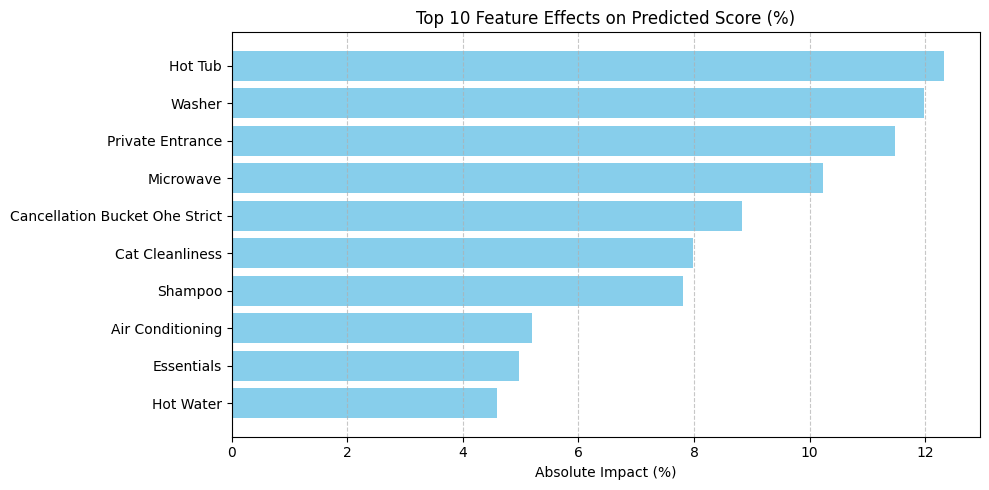

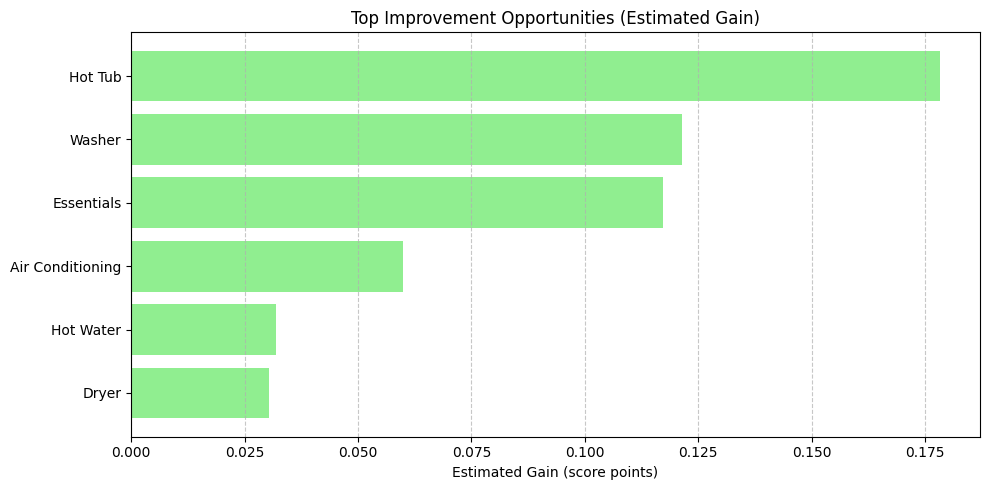


✅ Analysis Complete. Payload ready.


In [0]:

# 1. File Paths & IDs
INPUT_PATH = "/mnt/lab94290/cluster_19/airbnb_data_updateddd"  
TARGET_PROPERTY_ID = property_id              
# 2. Column Names
ID_COL = "property_id"
LABEL_COL = "ratings"
AMENITIES_RAW_COL = "amenities"

# 3. Currency Conversion (Table based)
FX_RATES_DATA = [("USD", 1.0), ("EUR", 1.05)] 
FX_RATES_DF = spark.createDataFrame(FX_RATES_DATA, ["currency", "to_usd"])

# 4. Features Lists
NUMERIC_FEATURES_BASE = [
    "price_per_guest"   
]

BOOL_FEATURES_BASE = [
    "is_super_host" # 0/1
]

CATEGORICAL_FEATURES = [
    "cancellation_bucket"       
]

CATEGORY_RATING_COLS = [
    "cat_cleanliness",          
    "cat_checkin",
    "cat_communication"
]

# 5. Global Amenities to always include
GLOBAL_IMPORTANT_AMENITIES = [
    "Wifi", "Air conditioning", "Heating", "Washer", "Dryer",
    "Free parking on premises", "Pool", "Hot tub", "Kitchen", "TV", "Hair dryer"
]

# 6. Schema for Amenities parsing
AMENITIES_SCHEMA = T.ArrayType(
    T.StructType([
        T.StructField("group_name", T.StringType(), True),
        T.StructField("items", T.ArrayType(
            T.StructType([
                T.StructField("name",  T.StringType(), True),
                T.StructField("value", T.StringType(), True)
            ])
        ), True)
    ])
)

def get_neighbors_by_geo_bucket(df, property_id, id_col="property_id", res_col="geo_bucket_res", bucket_col="geo_bucket", h3_prefix="h3_"):
    target = df.filter(F.col(id_col) == F.lit(property_id)).select(res_col, bucket_col).limit(1).collect()
    
    if not target:
        raise ValueError(f"property_id {property_id} not found")

    res = int(target[0][res_col])
    bucket = target[0][bucket_col]
    h3_col = f"{h3_prefix}{res}"
    
    # Filter neighbors
    neighbors_df = df.filter(F.col(h3_col) == F.lit(bucket))
    return neighbors_df

def extract_features(df, fx_rates_df):
    # 1. Currency Conversion
    df = df.withColumn("currency", F.when(F.col("currency").isNull(), F.lit("USD")).otherwise(F.col("currency")))
    df = df.join(fx_rates_df, on="currency", how="left")
    df = df.withColumn("price_usd", F.col("price") * F.col("to_usd"))
    
    # 2. Price per Guest
    df = df.withColumn("guests", F.when(F.col("guests").isNull() | (F.col("guests") <= 0), F.lit(1.0)).otherwise(F.col("guests")))
    df = df.withColumn("price_per_guest", F.when((F.col("price_usd").isNotNull()), F.col("price_usd") / F.col("guests")).otherwise(None))

    # 3. Cancellation Policy Parsing
    df = df.withColumn("cp_text", F.lower(F.col("cancellation_policy").cast("string")))
    df = df.withColumn("cancellation_bucket",
        F.when(F.col("cp_text").contains("no refund"), "strict")
        .when(F.col("cp_text").contains("partial refund"), "moderate")
        .when(F.col("cp_text").contains("full refund"), "flexible")
        .otherwise("unknown")
    )

    # 4. Extract Category Ratings
    def extract_cat(name):
        return F.regexp_extract(F.col("category_rating").cast("string"), f'"name":"{name}".*?"value":"([0-9\\.]+)"', 1).cast("double")

    df = df.withColumn("cat_cleanliness", extract_cat("Cleanliness"))
    df = df.withColumn("cat_checkin", extract_cat("Check-in"))
    df = df.withColumn("cat_communication", extract_cat("Communication"))

    # 5. Type Casting for Numerics (Ensuring Double Type for ML)
    for c in NUMERIC_FEATURES_BASE + BOOL_FEATURES_BASE:
        if c in df.columns:
            df = df.withColumn(c, F.col(c).cast("double"))
            
    # Target Label Casting
    if LABEL_COL in df.columns:
        df = df.withColumn(LABEL_COL, F.col(LABEL_COL).cast("double"))
            
    return df

def build_amenity_feature_df(df_in, id_col, top_k_local=15, global_list=None, raw_col="amenities"):
    """ Optimized version using manual aggregation instead of slow pivot """
    if global_list is None: global_list = []
    
    # 1. Parse JSON
    df_parsed = df_in.withColumn("amenities_parsed", F.from_json(F.col(raw_col).cast("string"), AMENITIES_SCHEMA))
    
    # 2. Explode to find top amenities - FIXED (Double Explode for Group -> Items)
    amenities_long = (
        df_parsed.select(F.col(id_col).alias("pid"), F.explode_outer("amenities_parsed").alias("group")) # קודם מפרקים קבוצות
        .select("pid", F.explode_outer("group.items").alias("item")) # ואז מפרקים את הפריטים בתוך הקבוצה
        .select("pid", F.lower(F.col("item.name")).alias("name")) # עכשיו השדה הוא String תקין
        .filter(F.col("name").isNotNull())
    )
    
    # Simple normalization (tv variants, etc.)
    amenities_long = amenities_long.withColumn("name", 
        F.when(F.col("name").contains("tv"), "tv")
         .when(F.col("name").contains("hair dryer"), "hair dryer")
         .otherwise(F.col("name"))
    )

    # 3. Determine Chosen Amenities (Local Top K + Global)
    local_top = (amenities_long.groupBy("name").count().orderBy(F.desc("count")).limit(top_k_local))
    local_list = [r["name"] for r in local_top.collect()]
    global_norm = [g.lower() for g in global_list]
    chosen_amenities = list(set(local_list + global_norm))

    # 4. Manual Pivot (Faster!) - Create 0/1 columns
    aggs = []
    amen_cols = []
    
    for amen in chosen_amenities:
        safe_name = "amen_" + amen.replace(" ", "_").replace("-", "_")
        amen_cols.append(safe_name)
        # אם המילה מופיעה ברשימה של הנכס = 1, אחרת 0
        aggs.append(F.max(F.when(F.col("name") == amen, 1.0).otherwise(0.0)).alias(safe_name))
    
    # Group by PID and calculate all flags at once
    features_df = amenities_long.groupBy("pid").agg(*aggs)
    
    # Join back to main DF
    df_out = df_in.join(features_df, df_in[id_col] == features_df["pid"], "left")
    
    # Fill nulls with 0
    df_out = df_out.fillna(0.0, subset=amen_cols)
    
    return df_out, amen_cols


# 1. Load Data
raw_df = spark.read.format("delta").load(INPUT_PATH)

# 2. Get Neighbors
df_similar = get_neighbors_by_geo_bucket(raw_df, TARGET_PROPERTY_ID)

# 3. Feature Extraction
df_similar = extract_features(df_similar, FX_RATES_DF)

# 4. Amenities Features
df_final, amenity_cols = build_amenity_feature_df(
    df_similar, 
    ID_COL, 
    top_k_local=20, 
    global_list=GLOBAL_IMPORTANT_AMENITIES
)

# 5. Define final list of columns for the model
FINAL_NUMERIC_COLS = [c for c in (NUMERIC_FEATURES_BASE + CATEGORY_RATING_COLS) if c in df_final.columns]
FINAL_BOOL_COLS = [c for c in BOOL_FEATURES_BASE if c in df_final.columns]
FINAL_AMENITY_COLS = amenity_cols
FINAL_CATEGORICAL_COLS = [c for c in CATEGORICAL_FEATURES if c in df_final.columns]

ALL_FEATURES_RAW = FINAL_NUMERIC_COLS + FINAL_BOOL_COLS + FINAL_AMENITY_COLS

print(f"Total features: {len(ALL_FEATURES_RAW) + len(FINAL_CATEGORICAL_COLS)}")
# Cache to speed up training
df_final.cache()
print("Data ready and cached.")


# Stages setup
stages = []

# 1. Imputer (Median)
imputer = Imputer(inputCols=ALL_FEATURES_RAW, outputCols=[f"{c}__imp" for c in ALL_FEATURES_RAW]).setStrategy("median")
stages.append(imputer)
imp_cols = [f"{c}__imp" for c in ALL_FEATURES_RAW]

# 2. OHE for Categoricals
ohe_cols = []
if FINAL_CATEGORICAL_COLS:
    indexer = StringIndexer(inputCols=FINAL_CATEGORICAL_COLS, outputCols=[f"{c}__idx" for c in FINAL_CATEGORICAL_COLS], handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[f"{c}__idx" for c in FINAL_CATEGORICAL_COLS], outputCols=[f"{c}__ohe" for c in FINAL_CATEGORICAL_COLS], handleInvalid="keep")
    stages.extend([indexer, encoder])
    ohe_cols = [f"{c}__ohe" for c in FINAL_CATEGORICAL_COLS]

# 3. Assembler & Scaler
assembler = VectorAssembler(inputCols=imp_cols + ohe_cols, outputCol="features_vec", handleInvalid="keep")
scaler = StandardScaler(inputCol="features_vec", outputCol="features_scaled", withMean=True, withStd=True)

# 4. Model (Linear Regression)
lr = LinearRegression(featuresCol="features_scaled", labelCol=LABEL_COL, maxIter=50, regParam=0.1, elasticNetParam=0.5)

stages.extend([assembler, scaler, lr])
pipeline = Pipeline(stages=stages)

# Train
train_df = df_final.filter((F.col(LABEL_COL).isNotNull()) & (F.col(ID_COL) != F.lit(TARGET_PROPERTY_ID)))
model = pipeline.fit(train_df)

print("Model trained successfully.")


def humanize_feature_name(s: str) -> str:
    if s is None:
        return s
    s = str(s)
    # remove leading 'amen_' 
    s = re.sub(r"^amen_", "", s)
    # remove trailing '_imp'
    s = re.sub(r"_imp$", "", s)
    # underscores -> spaces
    s = s.replace("_", " ")
    # clean extra spaces and title case
    s = re.sub(r"\s+", " ", s).strip()
    return s.title()

def display_charts(property_output_df, topN=10):
    pdf = property_output_df.toPandas().copy()

    if "feature" in pdf.columns:
        pdf["feature_label"] = pdf["feature"].apply(humanize_feature_name)
    else:
        pdf["feature_label"] = "Unknown"

    # Chart 1
    df1 = pdf.sort_values("impact_pct_abs", ascending=False).head(topN).iloc[::-1]
    if not df1.empty:
        fig1, ax1 = plt.subplots(figsize=(10, 5)) # יצירת אובייקט fig
        ax1.barh(df1["feature_label"], df1["impact_pct_abs"], color="skyblue")
        ax1.set_title(f"Top {topN} Feature Effects on Predicted Score (%)")
        ax1.set_xlabel("Absolute Impact (%)")
        ax1.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        display(fig1) 
        plt.close(fig1)

    # Chart 2
    df2 = (
        pdf[pdf["potential_gain_scaled"] > 0.01]
        .sort_values("potential_gain_scaled", ascending=False)
        .head(topN)
        .iloc[::-1]
    )

    if not df2.empty:
        fig2, ax2 = plt.subplots(figsize=(10, 5)) 
        ax2.barh(df2["feature_label"], df2["potential_gain_scaled"], color="lightgreen")
        ax2.set_title(f"Top Improvement Opportunities (Estimated Gain)")
        ax2.set_xlabel("Estimated Gain (score points)")
        ax2.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        display(fig2) 
        plt.close(fig2)

# --- 2. Main Logic: Explanation & JSON Builder ---

def explain_property_output(df, train_df, model, property_id, id_col, label_col, features_raw, categorical_cols=None, topK=60):
    if categorical_cols is None: categorical_cols = []
    target_row = df.filter(F.col(id_col) == F.lit(property_id)).limit(1)
    if target_row.count() == 0: raise ValueError(f"Property {property_id} not found")
    q = train_df.approxQuantile(label_col, [0.8], 0.001)[0]
    top_df = train_df.filter(F.col(label_col) >= q)
    mean_exprs = [F.avg(c).alias(c) for c in features_raw if c in top_df.columns]
    top_mean_row = top_df.agg(*mean_exprs).withColumn(id_col, F.lit("TOP_MEAN"))

    for cat_col in categorical_cols:
        if cat_col in top_df.columns:
            mode_row = top_df.groupBy(cat_col).count().orderBy(F.desc("count")).limit(1).collect()
            mode_val = mode_row[0][cat_col] if mode_row else "unknown"
            top_mean_row = top_mean_row.withColumn(cat_col, F.lit(mode_val))

    target_scored = model.transform(target_row)
    top_scored = model.transform(top_mean_row)
    attrs = target_scored.schema["features_vec"].metadata["ml_attr"]["attrs"]
    all_attrs = []
    for k in ["numeric", "binary", "nominal"]:
        if k in attrs: all_attrs.extend(attrs[k])
    all_attrs.sort(key=lambda x: x["idx"])
    feature_names_vec = [a["name"] for a in all_attrs]

    lr_model = model.stages[-1]
    coefs = lr_model.coefficients.toArray().tolist()
    coef_df = spark.createDataFrame(list(zip(feature_names_vec, coefs)), ["feature", "coef"])
    target_vec = target_scored.select(vector_to_array("features_scaled").alias("vec")).collect()[0]["vec"]
    top_vec = top_scored.select(vector_to_array("features_scaled").alias("vec")).collect()[0]["vec"]
    
    vec_df = spark.createDataFrame(
        [(i, float(target_vec[i]), float(top_vec[i])) for i in range(len(target_vec))],
        ["idx", "target_scaled", "top_scaled"]
    )
    
    idx_map = spark.createDataFrame(list(enumerate(feature_names_vec)), ["idx", "feature"])
    
    def melt_raw(row_df, val_name):
        stack_parts = []
        valid_cols = [c for c in features_raw if c in row_df.columns]
        for c in valid_cols:
            stack_parts.append(f"'{c}__imp', `{c}`") 
        stack_expr = f"stack({len(valid_cols)}, {', '.join(stack_parts)}) as (feature, {val_name})"
        return row_df.select(F.expr(stack_expr))

    target_raw_long = melt_raw(target_row, "target_value")
    top_raw_long = melt_raw(top_mean_row, "top_mean_value")

    final_df = (
        idx_map
        .join(coef_df, "feature")
        .join(vec_df, "idx")
        .join(target_raw_long, "feature", "left")
        .join(top_raw_long, "feature", "left")
        .withColumn("impact_value", F.col("coef") * F.col("target_scaled"))
        .withColumn("potential_gain_scaled", F.col("coef") * (F.col("top_scaled") - F.col("target_scaled")))
        .withColumn("abs_impact", F.abs(F.col("impact_value")))
        .orderBy(F.desc("abs_impact"))
    )
    
    total_impact = final_df.agg(F.sum("abs_impact")).collect()[0][0] or 1.0
    final_df = final_df.withColumn("impact_pct_abs", (F.col("abs_impact") / total_impact) * 100)
    
    df_clean = final_df.withColumn(
        "market_trend", 
        F.when(F.col("coef") > 0, "Positive (Good to have)")
         .when(F.col("coef") < 0, "Negative (Avoid)")
         .otherwise("Neutral")
    ).select(
        F.col("feature").alias("name"),
        F.col("target_value").alias("my_value"),      
        F.col("top_mean_value").alias("market_avg"),
        F.col("market_trend"),                                 
        F.col("impact_value").alias("current_impact"),
        F.col("potential_gain_scaled").alias("opportunity"), 
        F.col("impact_pct_abs").alias("importance_pct") 
    )

    json_list = [json.loads(r) for r in df_clean.limit(topK).toJSON().collect()]
    
    return final_df, json_list

# --- 3. Execution ---

dbutils.widgets.text("property_id", "40458495") 
target_property_id = dbutils.widgets.get("property_id")

print(f"🕵️ Analyzing Property: {target_property_id}...")

try:
    df_full, insights_list = explain_property_output(
        df=df_final,
        train_df=train_df,
        model=model,
        property_id=target_property_id, 
        id_col=ID_COL,
        label_col=LABEL_COL,
        features_raw=ALL_FEATURES_RAW,
        categorical_cols=FINAL_CATEGORICAL_COLS
    )

    print("\n" + "="*40)
    print("📊 VISUAL ANALYSIS")
    print("="*40)
    display_charts(df_full, topN=10)
    print("="*40 + "\n")


    final_output = {
        "status": "success",
        "property_id": target_property_id,
        "llm_context": {
            "insights": insights_list,
            "summary_note": "market_trend indicates correlation direction. opportunity is potential gain vs top performers."
        }
    }

except Exception as e:
    print(f"❌ Error occurred: {e}")
    final_output = {
        "status": "error",
        "message": str(e)
    }

output_json = json.dumps(final_output, ensure_ascii=False)
print("✅ Analysis Complete. Payload ready.")


#### USE LLM TO EXTRACT INSIGHTS FROM REGRESSION MODEL

put your question here in string format

In [0]:
user_q = "What amenties can improve my rating?"   # <---------------------------- put your question here in string format


Usage

In [0]:
#Usage
REGRESSION_PROMPT = """
You are a Senior Strategic Analyst specializing in Airbnb performance optimization. 
Your task is to interpret Regression Model outputs to help a host improve their property rating.

Key Data Definitions for your analysis:
1. "importance_pct": The relative weight of this feature in the overall prediction. High percentage means this feature is a major driver of the score.
2. "current_impact": How much this specific feature is currently helping (+) or hurting (-) the host's predicted score.
3. "opportunity": The estimated gain in points the host could achieve if they matched the market average for this feature.
4. "market_trend": Indicates if the market generally rewards this feature (Positive) or avoids it (Negative).

Your Goal:
- Answer the host's question based on the regression results.
- Identify the most "impactful" features they currently have.
- Highlight the "quick wins" (high opportunity scores).
- Explain technical regression terms in simple, actionable business English.
"""
ask_llm_expert(
    data_json=final_output["llm_context"]["insights"], 
    user_question=user_q, 
    system_prompt=REGRESSION_PROMPT,
    report_title="REGRESSION STRATEGY ANALYSIS"
)

📡 Sending request to Groq for: REGRESSION STRATEGY ANALYSIS...

✅ REGRESSION STRATEGY ANALYSIS
To improve your rating, let's analyze the regression model outputs. We'll focus on the most impactful features, quick wins, and provide actionable recommendations.

**Most Impactful Features:**

1. **Hot Tub** (importance_pct: 12.33%): Although you don't currently offer a hot tub (my_value: 0.0), the market trend is positive, indicating that having one could significantly improve your rating. The current impact is -0.11, and the opportunity for improvement is 0.18.
2. **Private Entrance** (importance_pct: 11.48%): You already offer a private entrance (my_value: 1.0), which has a positive current impact of 0.10. However, the opportunity for improvement is -0.18, suggesting that you're already doing well in this aspect.
3. **Washer** (importance_pct: 11.98%): You offer a washer (my_value: 1.0), but the market trend is negative, indicating that having one might not be as desirable. The current i

"To improve your rating, let's analyze the regression model outputs. We'll focus on the most impactful features, quick wins, and provide actionable recommendations.\n\n**Most Impactful Features:**\n\n1. **Hot Tub** (importance_pct: 12.33%): Although you don't currently offer a hot tub (my_value: 0.0), the market trend is positive, indicating that having one could significantly improve your rating. The current impact is -0.11, and the opportunity for improvement is 0.18.\n2. **Private Entrance** (importance_pct: 11.48%): You already offer a private entrance (my_value: 1.0), which has a positive current impact of 0.10. However, the opportunity for improvement is -0.18, suggesting that you're already doing well in this aspect.\n3. **Washer** (importance_pct: 11.98%): You offer a washer (my_value: 1.0), but the market trend is negative, indicating that having one might not be as desirable. The current impact is -0.10, and the opportunity for improvement is 0.12.\n\n**Quick Wins:**\n\n1. **

Trace(request_id=tr-2c09acf3658c4a64b4d7d9495b2e8412)

# Second Tool- NLP Tool
### Goal:
automated “property vs. similar nearby neighbors” review-analysis pipeline that selects comparable competitors via similarity vectors, extracts and tags review sentences by topic and sentiment, quantifies gaps in negative rates, and writes structured results (neighbors, topic gaps, and supporting evidence plus an impact-vs-confidence chart) to Delta for downstream agent responses.

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
🏃 View run bemused-conch-911 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871/runs/c1e1d913919f4d20ae9d9325c5fdbfaa
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871
sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]
🏃 View run bouncy-rook-755 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871/runs/637e1980883f40d298423638543499ea
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
🏃 View run abrasive-swan-93 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3680157061073871/runs/5baf93f9f65c4e9e8d6a16eb32d4f238
🧪 View experiment at: htt

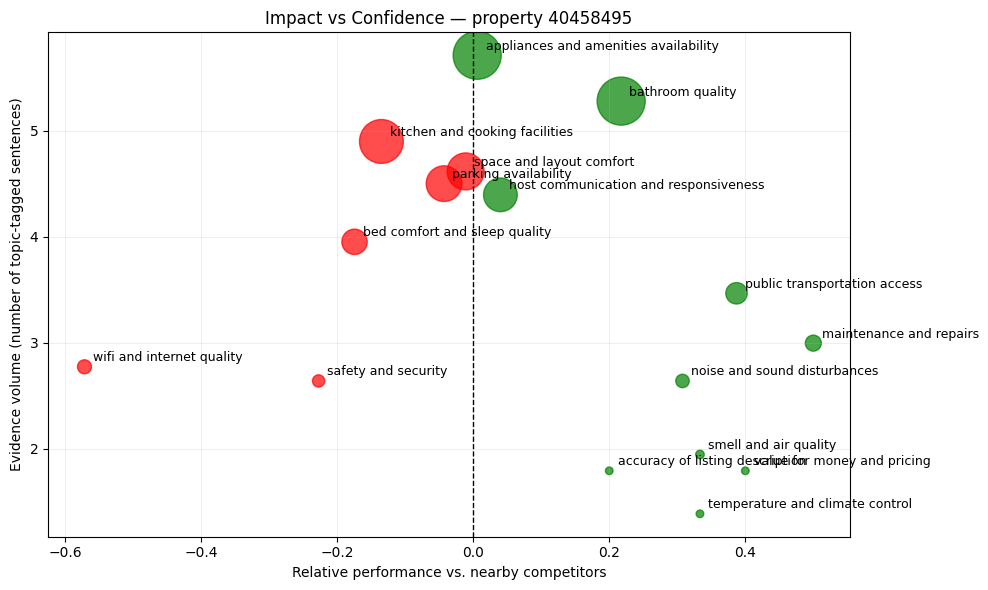


FINAL JSON OUTPUT
{
  "status": "ok",
  "run": {
    "run_id": "34bade5e-85f4-4e8f-8d4d-10fd64d364c8",
    "run_utc_ts": "2026-01-29T08:49:19Z",
    "property_id": "40458495"
  },
  "top_similar_neighbors": [
    {
      "property_id": "1101716585034426731",
      "similarity": 0.9999981502734374
    },
    {
      "property_id": "53595554",
      "similarity": 0.9999631428052741
    },
    {
      "property_id": "1095435869134685867",
      "similarity": 0.9999368952447791
    },
    {
      "property_id": "1293835918122852251",
      "similarity": 0.9998450382982708
    },
    {
      "property_id": "604594884034231792",
      "similarity": 0.9991360158007715
    },
    {
      "property_id": "1294485340977204684",
      "similarity": 0.676153920355582
    },
    {
      "property_id": "48368466",
      "similarity": 0.6471305193572796
    },
    {
      "property_id": "20158623",
      "similarity": 0.6337536529519284
    },
    {
      "property_id": "1283561781782820515",
      "

In [0]:

from __future__ import annotations
import uuid
import math
from datetime import datetime
from typing import Optional, Dict, Any, List, Tuple
import pandas as pd  

# Headless matplotlib for Databricks jobs
import matplotlib
matplotlib.use("Agg", force=True)
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.storagelevel import StorageLevel

# Spark NLP (assumed available)
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import (
    SentenceDetectorDLModel,
    Tokenizer,
    ViveknSentimentModel,
    UniversalSentenceEncoder,
)
dbutils.widgets.text("params_json", "")

DELTA_PATH = "/mnt/lab94290/cluster_19/airbnb_data_updateddd"
OUT_BASE_PATH = "/mnt/lab94290/cluster_19/out"
PID = property_id
PARAMS_JSON = dbutils.widgets.get("params_json").strip()

# -----------------------------
# Column names (adjust only if your schema differs)
# -----------------------------
ID_COL  = "property_id"
REV_COL = "reviews"
VEC_COL  = "similarity_vec"
BAD_COL  = "is_bad_vec"
NAN_COL  = "has_nan"
NORM_COL = "vec_norm"

# -----------------------------
# Topics list
# -----------------------------
TOPICS = [
    "cleanliness and hygiene",
    "maintenance and repairs",
    "smell and air quality",
    "noise and sound disturbances",
    "privacy and quietness",
    "safety and security",
    "bed comfort and sleep quality",
    "temperature and climate control",
    "space and layout comfort",
    "kitchen and cooking facilities",
    "bathroom quality",
    "wifi and internet quality",
    "appliances and amenities availability",
    "location and neighborhood",
    "public transportation access",
    "parking availability",
    "host communication and responsiveness",
    "check-in and check-out process",
    "accuracy of listing description",
    "value for money and pricing",
]


# =========================================================
# Chart function (Updated for Databricks Display)
# =========================================================
def plot_impact_vs_confidence_bubble(
    df: pd.DataFrame,
    *,
    max_labels: int = 12,
    title: Optional[str] = None,
) -> None:
    """
    Bubble chart:
      X = neighbors - target (impact; >=0 means neighbors worse OR target better)
      Y = confidence proxy = log1p(total topic assignments)
      Bubble size = neighbors_sentence_topic_assignments (market signal strength)
    """
    if df.empty:
        print("Warning: df is empty; nothing to plot.")
        return

    d = df.copy()
    d["total_assignments"] = d["target_sentence_topic_assignments"] + d["neighbors_sentence_topic_assignments"]
    d["confidence_y"] = d["total_assignments"].apply(lambda x: math.log1p(float(x)))
    d["bubble_size_raw"] = d["neighbors_sentence_topic_assignments"].astype(float)

    # Flip X: neighbors - target
    d["impact_x"] = -d["negative_rate_gap"].astype(float)

    # Size scaling
    q1 = float(d["bubble_size_raw"].quantile(0.10))
    q2 = float(d["bubble_size_raw"].quantile(0.90))
    if q2 <= q1:
        q1, q2 = float(d["bubble_size_raw"].min()), float(d["bubble_size_raw"].max())
    if q2 <= q1:
        q1, q2 = 0.0, 1.0

    def scale_size(v: float) -> float:
        v = float(v)
        t = 0.0 if q2 == q1 else (v - q1) / (q2 - q1)
        t = max(0.0, min(1.0, t))
        return 30.0 + t * (1200.0 - 30.0)

    d["bubble_s"] = d["bubble_size_raw"].apply(scale_size)

    # Color rule
    colors = ["green" if float(x) >= 0.0 else "red" for x in d["impact_x"]]
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(
        d["impact_x"],
        d["confidence_y"],
        s=d["bubble_s"],
        c=colors,
        alpha=0.7,
    )

    ax.axvline(0.0, color='black', linewidth=1, linestyle='--')
    ax.set_xlabel("Relative performance vs. nearby competitors")
    ax.set_ylabel("Evidence volume (number of topic-tagged sentences)")
    ax.grid(True, linewidth=0.5, alpha=0.3)

    if title is None:
        title = "Where your listing stands out — and where it falls behind"
    ax.set_title(title)

    # Label EVERY point with its topic
    for _, r in d.iterrows():
        ax.annotate(
            str(r["topic"]),
            (float(r["impact_x"]), float(r["confidence_y"])),
            textcoords="offset points",
            xytext=(6, 4),
            fontsize=9,
        )

    plt.tight_layout()
    

    display(fig) 
    plt.close(fig)


# =========================================================
# Helpers
# =========================================================
def _pick_geo_col(df: DataFrame) -> str:
    if "geo_bucket" in df.columns:
        return "geo_bucket"
    if "_geo_bucket_filled" in df.columns:
        return "_geo_bucket_filled"
    raise ValueError("No geo bucket column found: expected 'geo_bucket' or '_geo_bucket_filled'.")

def filter_english_like(df: DataFrame, text_col: str = "sentence_text", non_ascii_ratio_max: float = 0.20) -> DataFrame:
    non_ascii = F.length(F.col(text_col)) - F.length(F.regexp_replace(F.col(text_col), r"[^\x00-\x7F]", ""))
    total = F.greatest(F.length(F.col(text_col)), F.lit(1))
    non_ascii_ratio = non_ascii / total
    has_latin = F.col(text_col).rlike(r"[A-Za-z]")
    return df.filter(has_latin & (non_ascii_ratio <= F.lit(float(non_ascii_ratio_max))))

def _safe_head1(df: DataFrame):
    rows = df.take(1)
    return rows[0] if rows else None

def _plot_to_base64_png(plot_fn, *args, **kwargs) -> Optional[str]:
    """
    Runs a matplotlib plotting function and returns a base64-encoded PNG string.
    Safe for Databricks Jobs (headless). Returns None on failure.
    """
    old_show = None
    try:
        # Neutralize plt.show() for headless runs
        old_show = plt.show
        plt.show = lambda *a, **k: None

        plot_fn(*args, **kwargs)

        fig = plt.gcf()
        buf = io.BytesIO()
        fig.savefig(buf, format="png", dpi=120, bbox_inches="tight")
        plt.close(fig)
        buf.seek(0)
        return base64.b64encode(buf.getvalue()).decode("utf-8")
    except Exception:
        # Best-effort: never fail the job because of chart generation
        try:
            fig = plt.gcf()
            plt.close(fig)
        except Exception:
            pass
        return None
    finally:
        if old_show is not None:
            try:
                plt.show = old_show
            except Exception:
                pass


# =========================================================
# 1) Neighbors selection by cosine similarity in same geo bucket
# =========================================================
def top_similar_properties_with_metadata(
    df: DataFrame,
    target_property_id,
    *,
    max_candidates: int = 50,
    top_k: int = 20,
    seed: int = 42,
    oversample: float = 1.7,
) -> Tuple[DataFrame, Dict[str, Any]]:
    spark = df.sparkSession
    bucket_val_col = _pick_geo_col(df)

    if "geo_bucket_res" not in df.columns:
        raise ValueError("Missing required column 'geo_bucket_res' in df.")

    target_df = (
        df.filter(F.col(ID_COL).cast("string") == F.lit(str(target_property_id)))
          .select(
              F.col(ID_COL).cast("string").alias(ID_COL),
              F.col(bucket_val_col).alias("bucket_value"),
              F.col("geo_bucket_res").alias("bucket_res"),
              F.col(VEC_COL).alias(VEC_COL),
              *(F.col(c) for c in [BAD_COL, NAN_COL, NORM_COL] if c in df.columns),
          )
          .limit(1)
    )

    target_row = _safe_head1(
        target_df.select(
            F.col("bucket_value").alias("bucket_value"),
            F.col("bucket_res").cast("int").alias("bucket_res"),
            vector_to_array(F.col(VEC_COL)).alias("vec_arr"),
            (F.col(NORM_COL).cast("double").alias("vec_norm") if NORM_COL in df.columns else F.lit(None).alias("vec_norm")),
        )
    )

    empty_neighbors = spark.createDataFrame(
        [], schema=T.StructType([
            T.StructField(ID_COL, T.StringType(), True),
            T.StructField("similarity", T.DoubleType(), True),
        ])
    )

    if target_row is None:
        return empty_neighbors, {"target_property_id": str(target_property_id), "status": "target_not_found"}

    bucket_value = target_row["bucket_value"]
    bucket_res   = target_row["bucket_res"]
    target_arr   = target_row["vec_arr"]
    target_norm  = target_row["vec_norm"]

    if bucket_res is None:
        raise ValueError(f"Target property_id={target_property_id} has null geo_bucket_res.")
    if bucket_value is None:
        raise ValueError(f"Target property_id={target_property_id} has null {_pick_geo_col(df)} (bucket value).")

    h3_col = f"h3_{int(bucket_res)}"
    if h3_col not in df.columns:
        raise ValueError(f"Expected column '{h3_col}' (derived from geo_bucket_res={bucket_res}) not found in df.")

    # Compute target norm if missing
    if target_norm is None and target_arr is not None:
        s = 0.0
        for x in target_arr:
            s += float(x) * float(x)
        target_norm = s ** 0.5

    if target_arr is None or target_norm is None or float(target_norm) == 0.0:
        return empty_neighbors, {
            "target_property_id": str(target_property_id),
            "status": "target_vector_invalid",
            "bucket_res": int(bucket_res),
            "bucket_value": bucket_value,
            "h3_filter_column": h3_col,
        }

    cand = (
        df.filter(F.col(h3_col) == F.lit(bucket_value))
          .filter(F.col(ID_COL).cast("string") != F.lit(str(target_property_id)))  # exclude current property
          .filter(F.col(VEC_COL).isNotNull())
    )

    if BAD_COL in df.columns:
        cand = cand.filter(~F.col(BAD_COL))
    if NAN_COL in df.columns:
        cand = cand.filter(~F.col(NAN_COL))
    if NORM_COL in df.columns:
        cand = cand.filter(F.col(NORM_COL).isNotNull() & (F.col(NORM_COL) > 0))

    n_bucket = cand.count()
    frac = min(1.0, (float(max_candidates) * float(oversample)) / max(float(n_bucket), 1.0))

    cand = (
        cand.sample(withReplacement=False, fraction=frac, seed=int(seed))
            .limit(int(max_candidates))
    )

    target_arr_lit = F.array(*[F.lit(float(x)) for x in target_arr])
    cand_arr = vector_to_array(F.col(VEC_COL))
    cand = cand.withColumn("cand_arr", cand_arr).withColumn("target_arr", target_arr_lit)

    dot = F.expr(
        "aggregate("
        "  arrays_zip(cand_arr, target_arr),"
        "  cast(0.0 as double),"
        "  (acc, x) -> acc + (x['cand_arr'] * x['target_arr'])"
        ")"
    )

    if NORM_COL in df.columns:
        cand_norm = F.col(NORM_COL).cast("double")
    else:
        cand_norm = F.sqrt(
            F.expr(
                "aggregate("
                "  transform(cand_arr, x -> x * x),"
                "  cast(0.0 as double),"
                "  (acc, y) -> acc + y"
                ")"
            )
        )

    sim = (dot / (cand_norm * F.lit(float(target_norm)))).alias("similarity")

    neighbors_df = (
        cand.select(F.col(ID_COL).cast("string").alias(ID_COL), sim)
            .orderBy(F.desc("similarity"))
            .limit(int(top_k))
    )

    meta = {
        "target_property_id": str(target_property_id),
        "status": "ok",
        "bucket_res": int(bucket_res),
        "bucket_value": bucket_value,
        "h3_filter_column": h3_col,
        "bucket_candidate_count": int(n_bucket),
        "candidate_sampling_fraction": float(frac),
        "max_candidates_cap": int(max_candidates),
        "oversample_factor": float(oversample),
        "top_k_neighbors": int(top_k),
        "random_seed": int(seed),
    }

    return neighbors_df, meta


# =========================================================
# 2) Spark NLP models (fit once)
# =========================================================
_SPLIT_MODEL = None
_SENT_MODEL  = None
_EMB_MODEL   = None
_TOPICS_EMB_DF = None
_TOPICS_EMB_MODEL_NAME = None

def init_models(spark) -> None:
    global _SPLIT_MODEL, _SENT_MODEL
    if _SPLIT_MODEL is not None and _SENT_MODEL is not None:
        return

    dummy_reviews   = spark.createDataFrame([("x", "hello world. great stay!")], [ID_COL, "review_text"])
    dummy_sentences = spark.createDataFrame([("x", "great stay!")], [ID_COL, "sentence_text"])

    doc1 = DocumentAssembler().setInputCol("review_text").setOutputCol("document")
    sent_detector = (
        SentenceDetectorDLModel.pretrained("sentence_detector_dl", "en")
        .setInputCols(["document"])
        .setOutputCol("sentences")
    )
    _SPLIT_MODEL = Pipeline(stages=[doc1, sent_detector]).fit(dummy_reviews)

    doc2 = DocumentAssembler().setInputCol("sentence_text").setOutputCol("document")
    tok2 = Tokenizer().setInputCols(["document"]).setOutputCol("token")
    sent2 = (
        ViveknSentimentModel.pretrained()
        .setInputCols(["document", "token"])
        .setOutputCol("sentiment")
    )
    _SENT_MODEL = Pipeline(stages=[doc2, tok2, sent2]).fit(dummy_sentences)

def init_embedding_model(spark, use_model_name: str = "tfhub_use") -> None:
    global _EMB_MODEL, _TOPICS_EMB_DF, _TOPICS_EMB_MODEL_NAME
    if _EMB_MODEL is not None and _TOPICS_EMB_MODEL_NAME == use_model_name:
        return

    dummy = spark.createDataFrame([("x", "great stay")], [ID_COL, "sentence_text"])

    doc = DocumentAssembler().setInputCol("sentence_text").setOutputCol("document")
    use = (
        UniversalSentenceEncoder.pretrained(use_model_name, "en")
        .setInputCols(["document"])
        .setOutputCol("sentence_embeddings")
    )
    _EMB_MODEL = Pipeline(stages=[doc, use]).fit(dummy)

    _TOPICS_EMB_DF = None
    _TOPICS_EMB_MODEL_NAME = use_model_name

# =========================================================
# 3) Sentence extraction + sentiment
# =========================================================
def build_sentences_with_sentiment(
    df_subset: DataFrame,
    *,
    max_reviews_per_property: int = 50,
) -> DataFrame:
    if _SPLIT_MODEL is None or _SENT_MODEL is None:
        raise RuntimeError("Models not initialized. Call init_models(spark) before running analysis.")

    df_fixed = df_subset.withColumn(
        "reviews_array",
        F.from_json(F.col(REV_COL), T.ArrayType(T.StringType()))
    )

    df_fixed = df_fixed.withColumn(
        "reviews_array",
        F.when(
            F.col("reviews_array").isNotNull(),
            F.expr(f"slice(reviews_array, 1, {int(max_reviews_per_property)})")
        ).otherwise(F.array())
    )

    df_reviews = (
        df_fixed.select(
            F.col(ID_COL).cast("string").alias(ID_COL),
            F.posexplode_outer("reviews_array").alias("review_idx", "review_text")
        )
        .filter(F.col("review_text").isNotNull())
        .withColumn("review_text", F.regexp_replace(F.lower(F.col("review_text")), r"\s+", " "))
    )

    tmp = _SPLIT_MODEL.transform(df_reviews)

    df_sentences = (
        tmp.select(ID_COL, "review_idx", F.posexplode("sentences").alias("sent_idx", "sent_annot"))
           .withColumn("sentence_text", F.col("sent_annot.result"))
           .drop("sent_annot")
           .filter(F.col("sentence_text").isNotNull() & (F.length("sentence_text") > 0))
    )

    df_sentences = df_sentences.withColumn(
        "sentence_id",
        F.sha2(
            F.concat_ws(
                "||",
                F.col(ID_COL),
                F.col("review_idx").cast("string"),
                F.col("sent_idx").cast("string"),
                F.col("sentence_text"),
            ),
            256,
        )
    )

    scored = _SENT_MODEL.transform(df_sentences)

    return scored.select(
        ID_COL,
        "review_idx",
        "sent_idx",
        "sentence_id",
        "sentence_text",
        F.col("sentiment.result").getItem(0).alias("sentiment_label")
    )

# =========================================================
# 4) Topic tagging via USE embeddings + cosine to topic vectors
# =========================================================
def _get_topics_embeddings(spark) -> DataFrame:
    global _TOPICS_EMB_DF
    if _TOPICS_EMB_DF is not None:
        return _TOPICS_EMB_DF

    if _EMB_MODEL is None:
        raise RuntimeError("Embedding model not initialized. Call init_embedding_model(spark, ...)")

    topics_df = spark.createDataFrame([(t,) for t in TOPICS], ["sentence_text"])
    te = _EMB_MODEL.transform(topics_df)

    te = te.withColumn("topic_vector", F.col("sentence_embeddings")[0]["embeddings"]) \
           .drop("sentence_embeddings", "document") \
           .withColumnRenamed("sentence_text", "topic")

    te = te.withColumn(
        "topic_vector_norm",
        F.sqrt(
            F.expr(
                "aggregate(transform(topic_vector, x -> x * x), cast(0.0 as double), (acc, y) -> acc + y)"
            )
        )
    ).filter(F.col("topic_vector_norm") > 0)

    _TOPICS_EMB_DF = te.select("topic", "topic_vector", "topic_vector_norm")
    return _TOPICS_EMB_DF

def classify_topics_with_use(
    sent_df: DataFrame,
    *,
    similarity_threshold: float = 0.35,
    top_topics_per_sentence: Optional[int] = 2,
    non_ascii_ratio_max: float = 0.20,
    topic_partitions: Optional[int] = None,
) -> DataFrame:
    if _EMB_MODEL is None:
        raise RuntimeError("Embedding model not initialized. Call init_embedding_model(spark, ...)")

    spark = sent_df.sparkSession

    base = sent_df.select(
        F.col(ID_COL).cast("string").alias(ID_COL),
        "sentence_id",
        "sentence_text"
    )

    base = filter_english_like(base, text_col="sentence_text", non_ascii_ratio_max=float(non_ascii_ratio_max))

    if topic_partitions is not None:
        base = base.repartition(int(topic_partitions))

    se = _EMB_MODEL.transform(base)

    se = se.withColumn("sentence_vector", F.col("sentence_embeddings")[0]["embeddings"]) \
           .drop("sentence_embeddings", "document")

    se = se.withColumn(
        "sentence_vector_norm",
        F.sqrt(
            F.expr(
                "aggregate(transform(sentence_vector, x -> x * x), cast(0.0 as double), (acc, y) -> acc + y)"
            )
        )
    ).filter(F.col("sentence_vector_norm") > 0)

    topics_emb = F.broadcast(_get_topics_embeddings(spark))
    pairs = se.crossJoin(topics_emb)

    dot = F.expr(
        "aggregate("
        "  arrays_zip(sentence_vector, topic_vector),"
        "  cast(0.0 as double),"
        "  (acc, x) -> acc + (x['sentence_vector'] * x['topic_vector'])"
        ")"
    )

    scored = pairs.withColumn(
        "topic_similarity",
        dot / (F.col("sentence_vector_norm") * F.col("topic_vector_norm"))
    ).filter(F.col("topic_similarity") >= F.lit(float(similarity_threshold)))

    if top_topics_per_sentence is not None:
        w = Window.partitionBy(ID_COL, "sentence_id").orderBy(F.desc("topic_similarity"))
        scored = scored.withColumn("rn", F.row_number().over(w)) \
                       .filter(F.col("rn") <= int(top_topics_per_sentence)) \
                       .drop("rn")

    return scored.select(
        ID_COL,
        "sentence_id",
        "topic",
        F.col("topic_similarity").cast("double").alias("topic_similarity")
    )

# =========================================================
# 5) Report building (weaknesses + strengths + evidence)
# =========================================================
def _build_topic_report_df(
    enriched: DataFrame,
    *,
    target_property_id: str,
    top_k_weakness_topics: int,
    top_k_strength_topics: int,
    top_k_examples: int,
) -> Tuple[DataFrame, DataFrame]:
    my_df  = enriched.filter(F.col(ID_COL) == F.lit(str(target_property_id)))
    nbr_df = enriched.filter(F.col(ID_COL) != F.lit(str(target_property_id)))

    def agg(df: DataFrame, prefix: str) -> DataFrame:
        return (
            df.groupBy("topic")
              .agg(
                  F.count("*").alias(f"{prefix}_sentence_topic_assignments"),
                  F.sum(F.when(F.col("sentiment_label") == "negative", 1).otherwise(0)).alias(f"{prefix}_negative_assignments"),
              )
              .withColumn(
                  f"{prefix}_negative_rate",
                  F.when(
                      F.col(f"{prefix}_sentence_topic_assignments") > 0,
                      F.col(f"{prefix}_negative_assignments") / F.col(f"{prefix}_sentence_topic_assignments")
                  ).otherwise(F.lit(0.0))
              )
        )

    my_agg  = agg(my_df, "target")
    nbr_agg = agg(nbr_df, "neighbors")

    comp = (
        my_agg.join(nbr_agg, on="topic", how="outer")
              .na.fill(
                  0,
                  subset=[
                      "target_sentence_topic_assignments",
                      "target_negative_assignments",
                      "target_negative_rate",
                      "neighbors_sentence_topic_assignments",
                      "neighbors_negative_assignments",
                      "neighbors_negative_rate",
                  ],
              )
              .withColumn("negative_rate_gap", F.col("target_negative_rate") - F.col("neighbors_negative_rate"))
    )

    weaknesses_df = comp.orderBy(F.desc("negative_rate_gap")).limit(int(top_k_weakness_topics))
    strengths_df  = comp.orderBy(F.asc("negative_rate_gap")).limit(int(top_k_strength_topics))

    def attach_examples(df_topics: DataFrame) -> DataFrame:
        topics_only = df_topics.select("topic").distinct()

        evidence_struct = F.struct(
            F.col(ID_COL).alias("property_id"),
            F.col("review_idx").cast("int").alias("review_idx"),
            F.col("sent_idx").cast("int").alias("sent_idx"),
            F.col("sentence_id").alias("sentence_id"),
            F.col("topic_similarity").cast("double").alias("topic_similarity"),
            F.col("sentiment_label").alias("sentiment_label"),
            F.col("sentence_text").alias("sentence_text"),
        )

        w_t = Window.partitionBy("topic").orderBy(F.desc("topic_similarity"))
        target_negative_examples = (
            my_df.join(topics_only, on="topic", how="inner")
                .filter(F.col("sentiment_label") == "negative")
                .withColumn("rn", F.row_number().over(w_t))
                .filter(F.col("rn") <= int(top_k_examples))
                .groupBy("topic")
                .agg(F.collect_list(evidence_struct).alias("target_negative_examples"))
        )

        w_np = Window.partitionBy("topic").orderBy(F.desc("topic_similarity"))
        neighbors_positive_examples = (
            nbr_df.join(topics_only, on="topic", how="inner")
                 .filter(F.col("sentiment_label") == "positive")
                 .withColumn("rn", F.row_number().over(w_np))
                 .filter(F.col("rn") <= int(top_k_examples))
                 .groupBy("topic")
                 .agg(F.collect_list(evidence_struct).alias("neighbors_positive_examples"))
        )

        w_nn = Window.partitionBy("topic").orderBy(F.desc("topic_similarity"))
        neighbors_negative_examples = (
            nbr_df.join(topics_only, on="topic", how="inner")
                 .filter(F.col("sentiment_label") == "negative")
                 .withColumn("rn", F.row_number().over(w_nn))
                 .filter(F.col("rn") <= int(top_k_examples))
                 .groupBy("topic")
                 .agg(F.collect_list(evidence_struct).alias("neighbors_negative_examples"))
        )

        return (
            df_topics.join(target_negative_examples, on="topic", how="left")
                    .join(neighbors_positive_examples, on="topic", how="left")
                    .join(neighbors_negative_examples, on="topic", how="left")
                    .withColumn("target_negative_examples", F.coalesce(F.col("target_negative_examples"), F.array()))
                    .withColumn("neighbors_positive_examples", F.coalesce(F.col("neighbors_positive_examples"), F.array()))
                    .withColumn("neighbors_negative_examples", F.coalesce(F.col("neighbors_negative_examples"), F.array()))
        )

    return attach_examples(weaknesses_df), attach_examples(strengths_df)

def analyze_property_realtime_payload(
    listings_df: DataFrame,
    sim_df: DataFrame,
    pid: str,
    *,
    similarity_threshold: float = 0.35,
    top_topics_per_sentence: int = 2,
    top_k_weakness_topics: int = 8,
    top_k_strength_topics: Optional[int] = None,
    top_k_examples: int = 3,
    max_reviews_per_property: int = 50,
    max_candidates: int = 50,
    top_k_neighbors: int = 20,
    seed: int = 42,
    oversample: float = 1.7,
    use_model_name: str = "tfhub_use",
    non_ascii_ratio_max: float = 0.20,
    topic_partitions: Optional[int] = None,
    as_json_string: bool = True,
) -> Any:

    def _struct_list_to_dict_list(struct_list):
        if not struct_list:
            return []
        out = []
        for s in struct_list:
            out.append({
                "property_id": s["property_id"],
                "review_idx": int(s["review_idx"]) if s["review_idx"] is not None else None,
                "sent_idx": int(s["sent_idx"]) if s["sent_idx"] is not None else None,
                "sentence_id": s["sentence_id"],
                "topic_similarity": float(s["topic_similarity"]) if s["topic_similarity"] is not None else None,
                "sentiment_label": s["sentiment_label"],
                "sentence_text": s["sentence_text"],
            })
        return out

    spark = listings_df.sparkSession

    if top_k_strength_topics is None:
        top_k_strength_topics = int(top_k_weakness_topics)


    init_models(spark)
    init_embedding_model(spark, use_model_name=use_model_name)
    neighbors_df, neighbor_meta = top_similar_properties_with_metadata(
        df=sim_df,
        target_property_id=pid,
        max_candidates=max_candidates,
        top_k=top_k_neighbors,
        seed=seed,
        oversample=oversample,
    )

    neighbors_rows = neighbors_df.orderBy(F.desc("similarity")).collect()
    neighbor_ids: List[str] = [r[ID_COL] for r in neighbors_rows]
    neighbor_sims: List[float] = [float(r["similarity"]) if r["similarity"] is not None else None for r in neighbors_rows]

    sim_vals = [s for s in neighbor_sims if s is not None]
    neighbor_similarity_stats = {
        "neighbors_selected_count": int(len(neighbor_ids)),
        "similarity_avg": float(sum(sim_vals) / len(sim_vals)) if sim_vals else None,
        "similarity_min": float(min(sim_vals)) if sim_vals else None,
        "similarity_max": float(max(sim_vals)) if sim_vals else None,
    }

    neighbor_list = [
        {"neighbor_property_id": nid, "similarity": float(s) if s is not None else None}
        for nid, s in zip(neighbor_ids, neighbor_sims)
    ]

    ids_df = (
        spark.createDataFrame([(str(pid),)], [ID_COL])
             .unionByName(neighbors_df.select(ID_COL))
             .distinct()
    )

    df_subset = (
        listings_df.select(F.col(ID_COL).cast("string").alias(ID_COL), F.col(REV_COL))
                   .join(ids_df, on=ID_COL, how="inner")
    )

    sent_df = build_sentences_with_sentiment(
        df_subset=df_subset,
        max_reviews_per_property=max_reviews_per_property
    ).persist(StorageLevel.MEMORY_AND_DISK)

    sent_counts = sent_df.groupBy(ID_COL).agg(F.countDistinct("sentence_id").alias("distinct_sentences"))
    target_sentence_count_row = _safe_head1(sent_counts.filter(F.col(ID_COL) == F.lit(str(pid))))
    target_distinct_sentences = int(target_sentence_count_row["distinct_sentences"]) if target_sentence_count_row else 0
    
    neighbors_distinct_sentences = int(
        sent_counts.filter(F.col(ID_COL) != F.lit(str(pid)))
                   .agg(F.sum("distinct_sentences").alias("s"))
                   .first()["s"] or 0
    )

    topics_df = classify_topics_with_use(
        sent_df=sent_df,
        similarity_threshold=similarity_threshold,
        top_topics_per_sentence=top_topics_per_sentence,
        non_ascii_ratio_max=non_ascii_ratio_max,
        topic_partitions=topic_partitions,
    ).persist(StorageLevel.MEMORY_AND_DISK)

    enriched = (
        sent_df.join(topics_df, on=[ID_COL, "sentence_id"], how="inner")
              .select(
                  F.col(ID_COL).cast("string").alias(ID_COL),
                  F.col("review_idx").cast("int").alias("review_idx"),
                  F.col("sent_idx").cast("int").alias("sent_idx"),
                  F.col("sentence_id").alias("sentence_id"),
                  F.col("topic").alias("topic"),
                  F.col("topic_similarity").cast("double").alias("topic_similarity"),
                  F.col("sentiment_label").alias("sentiment_label"),
                  F.col("sentence_text").alias("sentence_text"),
              )
              .persist(StorageLevel.MEMORY_AND_DISK)
    )

    weaknesses_df, strengths_df = _build_topic_report_df(
        enriched=enriched,
        target_property_id=str(pid),
        top_k_weakness_topics=int(top_k_weakness_topics),
        top_k_strength_topics=int(top_k_strength_topics),
        top_k_examples=int(top_k_examples),
    )

    weaknesses = []
    for r in weaknesses_df.collect():
        weaknesses.append({
            "topic": r["topic"],
            "target_sentence_topic_assignments": int(r["target_sentence_topic_assignments"]),
            "target_negative_assignments": int(r["target_negative_assignments"]),
            "target_negative_rate": float(r["target_negative_rate"]),
            "neighbors_sentence_topic_assignments": int(r["neighbors_sentence_topic_assignments"]),
            "neighbors_negative_assignments": int(r["neighbors_negative_assignments"]),
            "neighbors_negative_rate": float(r["neighbors_negative_rate"]),
            "negative_rate_gap": float(r["negative_rate_gap"]),
            "target_negative_examples": _struct_list_to_dict_list(r["target_negative_examples"]),
            "neighbors_positive_examples": _struct_list_to_dict_list(r["neighbors_positive_examples"]),
            "neighbors_negative_examples": _struct_list_to_dict_list(r["neighbors_negative_examples"]),
        })

    strengths = []
    for r in strengths_df.collect():
        strengths.append({
            "topic": r["topic"],
            "target_sentence_topic_assignments": int(r["target_sentence_topic_assignments"]),
            "target_negative_assignments": int(r["target_negative_assignments"]),
            "target_negative_rate": float(r["target_negative_rate"]),
            "neighbors_sentence_topic_assignments": int(r["neighbors_sentence_topic_assignments"]),
            "neighbors_negative_assignments": int(r["neighbors_negative_assignments"]),
            "neighbors_negative_rate": float(r["neighbors_negative_rate"]),
            "negative_rate_gap": float(r["negative_rate_gap"]),
            "target_negative_examples": _struct_list_to_dict_list(r["target_negative_examples"]),
            "neighbors_positive_examples": _struct_list_to_dict_list(r["neighbors_positive_examples"]),
            "neighbors_negative_examples": _struct_list_to_dict_list(r["neighbors_negative_examples"]),
        })

    chart_rows = (weaknesses or []) + (strengths or [])
    seen_topics = set()
    uniq = []
    for rr in chart_rows:
        t = rr.get("topic")
        if t is None or t in seen_topics:
            continue
        seen_topics.add(t)
        uniq.append({
            "topic": t,
            "negative_rate_gap": float(rr.get("negative_rate_gap") or 0.0),
            "target_sentence_topic_assignments": int(rr.get("target_sentence_topic_assignments") or 0),
            "neighbors_sentence_topic_assignments": int(rr.get("neighbors_sentence_topic_assignments") or 0),
        })

    if uniq:
        print(f"\n📊 Generating Impact Analysis Chart for property {pid}...")
        chart_df = pd.DataFrame(uniq)
        plot_impact_vs_confidence_bubble(
            chart_df, 
            max_labels=12, 
            title=f"Impact vs Confidence — property {pid}"
        )
        plt.show()

    payload: Dict[str, Any] = {
        "target_property_id": str(pid),
        "neighbors": {
            "neighbor_list": neighbor_list,
            "similarity_stats": neighbor_similarity_stats,
            "selection_metadata": neighbor_meta,
        },
        "text_volume": {
            "target_distinct_sentences_used": int(target_distinct_sentences),
            "neighbors_distinct_sentences_used": int(neighbors_distinct_sentences),
            "max_reviews_per_property_cap": int(max_reviews_per_property),
        },
        "topic_tagging_config": {
            "embedding_model": str(use_model_name),
            "similarity_threshold": float(similarity_threshold),
            "top_topics_per_sentence": int(top_topics_per_sentence),
            "non_ascii_ratio_max": float(non_ascii_ratio_max),
        },
        "results": {
            "weaknesses_vs_neighbors": weaknesses,
            "strengths_vs_neighbors": strengths,
        }
    }

    sent_df.unpersist()
    topics_df.unpersist()
    enriched.unpersist()

    return json.dumps(payload, ensure_ascii=False) if as_json_string else payload

# =========================================================
# 6) Job main: load data, run analysis, EXIT REQUESTED JSON (NO WRITES)
# =========================================================
DEFAULT_PARAMS = dict(
    similarity_threshold=0.35,
    top_topics_per_sentence=2,
    top_k_weakness_topics=8,
    top_k_strength_topics=8,
    top_k_examples=3,
    max_reviews_per_property=50,
    max_candidates=100,
    top_k_neighbors=20,
    seed=42,
    oversample=1.7,
    use_model_name="tfhub_use",
    non_ascii_ratio_max=0.20,
    topic_partitions=None,
)


def _parse_params_json(s: str) -> dict:
    if not s:
        return {}
    obj = json.loads(s)
    if not isinstance(obj, dict):
        raise ValueError("params_json must decode to a JSON object (dict).")
    return obj


def _extract_sentence_texts(evidence_list: List[Dict[str, Any]]) -> List[str]:
    # Return only sentence_text, keep ordering, drop nulls
    out = []
    for e in (evidence_list or []):
        txt = e.get("sentence_text")
        if txt:
            out.append(txt)
    return out


spark = SparkSession.getActiveSession() or SparkSession.builder.getOrCreate()
run_id = str(uuid.uuid4())
ts = datetime.utcnow().isoformat(timespec="seconds") + "Z"

result = None  # single result object to exit with

try:
    user_params = _parse_params_json(PARAMS_JSON)
    params = {**DEFAULT_PARAMS, **user_params}

    airbnb_df = spark.read.format("delta").load(DELTA_PATH)
    sim_df = airbnb_df

    payload = analyze_property_realtime_payload(
        listings_df=airbnb_df,
        sim_df=sim_df,
        pid=str(PID),
        as_json_string=False,
        **params,
    )

    # --- Map internal payload -> requested schema ---
    top_neighbors = []
    for x in (payload.get("neighbors", {}).get("neighbor_list", []) or []):
        top_neighbors.append(
            {
                "property_id": str(x.get("neighbor_property_id")) if x.get("neighbor_property_id") is not None else None,
                "similarity": float(x.get("similarity")) if x.get("similarity") is not None else None,
            }
        )

    weaknesses_in = payload.get("results", {}).get("weaknesses_vs_neighbors", []) or []
    strengths_in = payload.get("results", {}).get("strengths_vs_neighbors", []) or []

    weaknesses_out = []
    for t in weaknesses_in:
        weaknesses_out.append(
            {
                "topic": t.get("topic"),
                "negative_rate_gap": float(t.get("negative_rate_gap")) if t.get("negative_rate_gap") is not None else None,
                "evidence": {
                    "target_negative": _extract_sentence_texts(t.get("target_negative_examples", [])),
                    "neighbors_positive": _extract_sentence_texts(t.get("neighbors_positive_examples", [])),
                    "neighbors_negative": _extract_sentence_texts(t.get("neighbors_negative_examples", [])),
                },
            }
        )

    strengths_out = []
    for t in strengths_in:
        strengths_out.append(
            {
                "topic": t.get("topic"),
                "negative_rate_gap": float(t.get("negative_rate_gap")) if t.get("negative_rate_gap") is not None else None,
                "evidence": {
                    "target_positive": _extract_sentence_texts(t.get("target_positive_examples", [])),
                    "neighbors_negative": _extract_sentence_texts(t.get("neighbors_negative_examples", [])),
                    "neighbors_positive": _extract_sentence_texts(t.get("neighbors_positive_examples", [])),
                },
            }
        )

    warnings = []
    topics_chart = (payload.get("ui_artifacts", {}) or {}).get("charts", {}).get("topics_chart")
    if topics_chart is None:
        warnings.append("Charts omitted.")

    result = {
        "status": "ok",
        "run": {
            "run_id": run_id,
            "run_utc_ts": ts,
            "property_id": str(PID),
        },
        "top_similar_neighbors": top_neighbors,
        "summary": {
            "main_weakness_topics": [x.get("topic") for x in weaknesses_out if x.get("topic") is not None],
            "main_strength_topics": [x.get("topic") for x in strengths_out if x.get("topic") is not None],
        },
        "topics": {
            "weaknesses": weaknesses_out,
            "strengths": strengths_out,
        },
        "ui_artifacts": payload.get("ui_artifacts", {}),
        "warnings": warnings,
    }

except Exception as e:
    err_msg = str(e)
    result = {
        "status": "error",
        "run": {
            "run_id": run_id,
            "run_utc_ts": ts,
            "property_id": str(PID),
        },
        "error_message": err_msg[:4000],
    }

print("\n" + "="*50)
print("FINAL JSON OUTPUT")
print("="*50)
print(json.dumps(result, indent=2, ensure_ascii=False))
print("="*50 + "\n")



#### USE LLM TO EXTRACT INSIGHTS FROM NLP MODEL

put your question here in string format

In [0]:
user_question = "How is my cleanliness rating compared to my neighbors?"        # <-------put your question here in string format

Usage

In [0]:
#Usage
SYSTEM_PROMPT = """
You are an expert Airbnb Data Analyst. Your task is to answer the host's questions based on the provided JSON analysis data.
The data compares the host's property (Target) against a group of similar properties (Neighbors).

Analysis Guidelines:
1. "negative_rate_gap": A higher positive number means the host is performing worse than neighbors in that specific topic.
2. "importance_pct": Indicates how much this topic impacts the overall rating.
3. "evidence": Use actual quotes from the 'sentence_text' fields to support your findings.
4. Tone: Professional, data-driven, and actionable.
5. Missing Data: If the user asks about a topic not present in the JSON, politely inform them.

Please provide a structured response including:
- A direct answer to the question.
- Key data points (gaps, volumes).
- Specific examples/quotes from guests.
- One clear recommendation for improvement.
"""

if 'result' in locals():
    
    ask_llm_expert(
        data_json=result, 
        user_question=user_question, 
        system_prompt=SYSTEM_PROMPT, 
        report_title="COMPETITIVE TOPIC REPORT"
    )

📡 Sending request to Groq for: COMPETITIVE TOPIC REPORT...

✅ COMPETITIVE TOPIC REPORT
**Direct Answer:** 
Unfortunately, the provided JSON analysis data does not contain a specific topic related to "cleanliness" that directly compares your property's cleanliness rating to that of your neighbors. However, there are mentions of cleanliness in various topics, indicating that your property is often described as "clean" and "super clean" by guests.

**Key Data Points:**
- While there isn't a direct comparison for cleanliness, the "summary" section highlights "maintenance and repairs" as one of your strengths, which might indirectly relate to cleanliness, given that well-maintained properties are often clean and well-kept.
- The "topics" section, under both "weaknesses" and "strengths," does not explicitly list cleanliness as a separate topic for comparison.

**Specific Examples/Quotes:**
- Guests have complimented your property, mentioning it is "super clean" and that the "apartment was on

Trace(request_id=tr-33d2834ffc834f31aa40b9c40b5f4835)